# Relatório Final
___
### João Guilherme Almeida

In [4]:
import subprocess
import time
import random
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
def roda_com_entrada(ex, in_f):
    with open(in_f) as f:
        start = time.perf_counter()
        proc = subprocess.run([ex], input=f.read(), text=True, capture_output=True)
        end = time.perf_counter()
        return proc.stdout, end-start, 

# Introdução

O projeto aqui presente tem o intuíto de trabalhar o problema de pareamento de sequências de DNA, ou seja, encontrar a similiaridade entre duas sequências de nucleotídeos.

Para tanto, foi se debruçado sobre diversas estratégias que buscam encontrar o melhor score possível para a similiaridade entre as sequências, essas sendo:

1. Heurística com Simth Waterman
2. Busca Local com aleatoriedade
3. Busca Exaustiva

Além disso, para aprimorar a execução, foram implementados os seguintes métodos de otimização na busca exaustiva:
1. Open MP
2. Parelização com GPU


# Gerando Arquivos de Entrada

Serão gerados diversos arquivos de entradas de tamanhos diversos. Isso pois para comparar as heuristicas é interessante que essas sejam submetidas a tamanhos diferentes de entradas para avaliar, não só a qualidade delas, como também, o tempo de execução por exemplo.

Foram criados 400 arquivos de entrada para as heuristicas ingênuas e de busca local, e a forma de fazer os arquivos para busca exaistiva será diferente. Além disso, 5 arquivos de entrada terão as duas sequencias de mesmo tamanho, porém conteúdos diferentes. Por fim, para fazer a segunda sequência maior, foi adicionado 2 ao tamanho da primeira.

In [6]:
for i in range(1, 400, 5): 
    for e in range(0,5):
        n = i
        m = i + 2
        file = "./inputs/dna{0}_{1}.seq".format(i,e)
        f = open(file, 'w')
        seq=[str(n)+'\n',
             str(m)+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=m))]
        f.writelines(seq)
        f.close()

Os arquivos de testes são estruturados da seguinte forma:
1. A primeira e a segunda linha do arquivo gerado representam o tamanho da primeira e da segunda sequência respectivamente
2. As duas últimas representam as sequências em si

# Heuristica com Smith Wallerman

O algoritmo de Smith Wallerman se apropria de matrizes e combinações de sequências de algarismos para entregar uma nota de combinção entre estas. Esta nota é calculada através do match, missmatch e gap ou seja, quando o par de caractéres (no caso do projeto as bases nitrogenadas) são iguais, diferentes ou uma encontra uma vazia, respectivamente. É importante notar que esse algorítimo se baseia muito em exploitation.

Com os arquivos de entrada gerados, é inicializado os teste em si. Primeiramente serão analizados os resultados e duração dos testes para a heurística ingênua com a ulitazação do alagoritimo de Smith Wallerman. Para isso, foi gerado, em primeiro lugar, uma lista com o caminho dos arquivos de entrada:

In [7]:
arqs = [f'./inputs/dna{i}_{e}.seq' for i in range(1,400,5) for e in range(0,5)]

Com isso, para cada grupo de arquivos com mesmo tamanho de entradas, é realizado o teste do grupo e armazenado o tempo de execução para cada uma desta.

In [8]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_Heuristica = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada("./ingenuo/ingenuo", arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_Heuristica.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [9]:
N_Heuristica = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_Heuristica.append(n)
        contador = 0
print(N_Heuristica)


[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396]


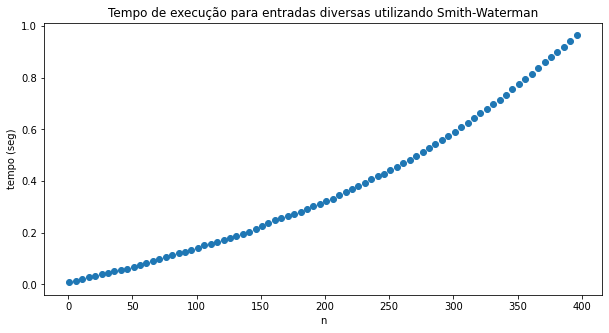

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_Heuristica, tempos_Heuristica)
plt.title("Tempo de execução para entradas diversas utilizando Smith-Waterman")
plt.show()

Observa-se que, primeiramente, que a execução da heurística ingênua é muito rápida, fazendo com que todos os 400 arquivos fossem rodados em poquissimos segundos, mesmo para uma entrada muito grande.

___

# Busca Local

Busca local é um algorítimo que se baseia mais em exploration e em pouco exploitation. Este se apropria de aleatoriedade para gerar as subsequências de diferentes tamanhos, assim através dessas sequências aleatórias calcula-se a pontuação e monta-se as sequências A e B resultantes da melhor pontuação.

Para o algorítimo de busca local, foi necessário aumentar o step de quais arquivos seriam utlizados, ou seja, diminuir o intervalo de entradas. Ainda assim, foi possível realizar o teste para entradas muito longas, com n chegando a quase 400.

In [11]:
arqs = [f'./inputs/dna{i}_{e}.seq' for i in range(1,400,15) for e in range(0,5)]

In [12]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_local = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./busca_local/busca_local', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_local.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [13]:
N_local = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_local.append(n)
        contador = 0
print(N_local)


[1, 16, 31, 46, 61, 76, 91, 106, 121, 136, 151, 166, 181, 196, 211, 226, 241, 256, 271, 286, 301, 316, 331, 346, 361, 376, 391]


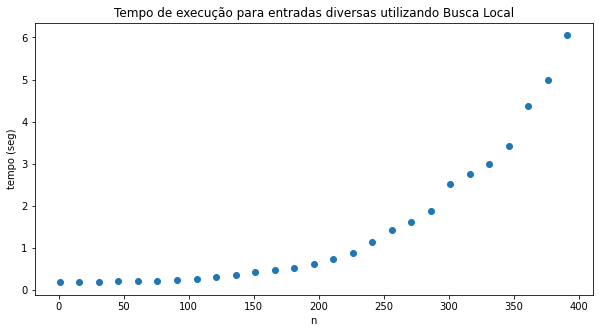

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_local, tempos_local)
plt.title("Tempo de execução para entradas diversas utilizando Busca Local")
plt.show()

Ao realizar o teste com busca local, é possível concluir que este é muito demorado. Isso se dá principalmente porque ele tem que quebrar uma das sequencias de entrada em partes menores (utilizando p e k) e testar a combinação dessas partes com a outra sequência várias vezes. Foi necessário diminuir a quantidade de vezes que o algorítimo faz diferentes quebras de 100 para 10, para que o tempo seja possível de realizar.

# Busca Exaustiva com auxílio de Smith-Waterman

Busca exaustiva é um algorítimo que foca-se muito em exploration, sendo assim este gera todas as possíveis subsequências para conseguir encontrar a melhor combinação das sequências de entrada.

Os arquivos de entrada para busca exaustiva tiveram que mudar muito. Primeiramente foi testado localmente que a demora para entradas com tamanhos maiores que 80 eram extremamente altas. Com isso, foi estabelicido que o máximo que a entrada possa ser era 70. Além disso, para não demorar muito, foi diminuido a quantidade de arquivos de entrada.

In [15]:
for i in range(5, 65, 3):
    for e in range (0,5):
        n = i
        m = i + 5
        file = "./inputs_exaust/dna{0}_{1}.seq".format(i,e)# nome do arquivo a ser gerado
        f = open(file, 'w')
        seq=[str(n)+'\n',
             str(m)+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=m))]
        f.writelines(seq)
        f.close()

In [16]:
arqs = [f'./inputs_exaust/dna{i}_{e}.seq' for i in range(5,65,3) for e in range(0,5)]

In [17]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_exaust = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./busca_exaustiva/busca_exaustiva', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_exaust.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [18]:
N_exaust = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_exaust.append(n)
        contador = 0
print(N_exaust)


[5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62]


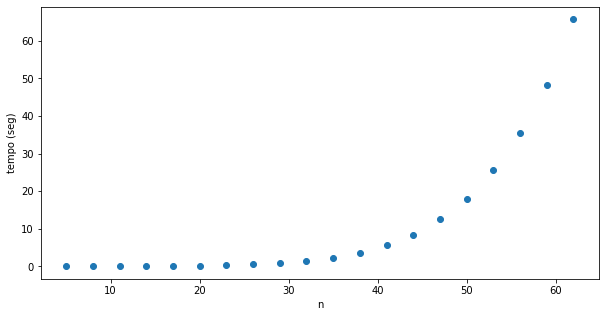

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_exaust, tempos_exaust)
plt.show()

Busca Exaustiva é muito demorado porque além do que o busca local faz, esse quebra as duas sequências em todas as subsquências possíveis, logo tem que fazer o dobro do esforço.

___

# Busca Exaustiva com truncagem

In [20]:
arqs = [f'./inputs_exaust/dna{i}_{e}.seq' for i in range(5,65,3) for e in range(0,5)]

In [21]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_exaust_trunc = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./busca_exaustiva/busca_exaustiva_trunc', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_exaust_trunc.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [22]:
N_exaust_trunc = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_exaust_trunc.append(n)
        contador = 0
print(N_exaust_trunc)


[5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62]


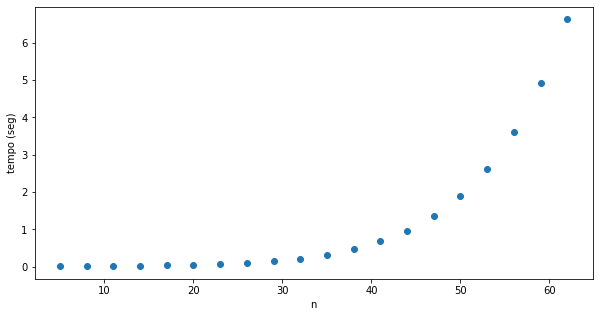

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_exaust_trunc, tempos_exaust_trunc)
plt.show()

___

# Paralelismo CPU

Ao realizar o teste de execução com o busca exaustiva não truncado, é possível perceber que, como esperado, o algorítimo atinge o melhor score. Porém atingir tal qualidade custa caro, já que o tempo de realização deste é muito longo. Isso se dá majoritariamente por estarmos tratando sequencialmente o problema, ou seja, quebrando as sequências em todas as subsequências possíveis e fazendo o teste de comparação para cada par, uma depois da outra. 

Dessa forma, para poder diminuir o tempo de execução, vamos alterar a metodologia de sequencial para paralelizada. Primeiramente, vamos testar com a parelização na CPU, se apropriando da biblioteca OpenMP, a qual utiliza diversas threads da CPU para executar uma parte específica do programa.

A questão inicial nessa etapa seria questionar qual parte do código poderia ser paralelizado. Para responder isso, basta imaginar qual é a parte sequencial do código, que poderia ser duas partes, ou a geração das subsequências ou o cálculo do score. Em tese, o ideal para parelelizar, seria fazer ambas as etapas com OpenMP, mas vamos fazer apenas no cálculo do score e ver o quanto melhora e recomendar que uma próxima iteração seria implementar o OpenMP na criação de subsequências também.

![image.png](attachment:image.png)

Para implementar, foi necessário criar um struc que era composto por uma variavel numérica (score) e duas strings (subsequenciaA e subsequenciaB). Além disso, foi criado um vetor desse struct. Assim, logo antes de calcular o score das subsquencias era necessário montar esse vetor com todas as subsequencias e scores 0. Com o vetor montado, foi realizado um paralell for que usava a paralelização das threads para calcular o score das subsequencias, de maneira paralelizada 

In [24]:
arqs = [f'./inputs_exaust/dna{i}_{e}.seq' for i in range(5,65,3) for e in range(0,5)]

In [25]:
qnt_iguais = 4
tempos_entrada_igual = []
tempo_medio = 0
tempos_exaust_par_cpu = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./paralelismo_CPU/paralelismo_exaustivo_par', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_exaust_par_cpu.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [26]:
N_exaust_par_cpu = []
qnt_iguais = 4
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_exaust_par_cpu.append(n)
        contador = 0
print(N_exaust_par_cpu)


[5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62]


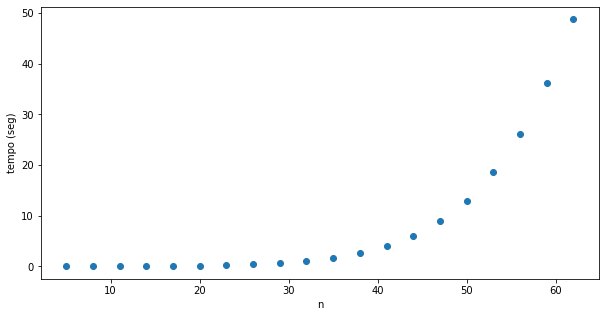

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_exaust_par_cpu, tempos_exaust_par_cpu)
plt.show()

# Paralelização GPU

A paralelização de dados na GPU pode aparecer atraente no cenário de alinhamento de DNA, já que é uma peça de hardware muito poderosa. Porém, é necessário entender que o nível de processamento da GPU não é signifcamente superior à da CPU. Ainda assim, é possível que a GPU cumpra a tarefa de encontrar o score de maneira mais rápida.

Isso se dá pela qualidade de throughput que a GPU tem, ou seja, a alta vazão que ela apresenta. Em outras palavras, é possível entregar muitos dados a GPU e receber as alterações deles em grande volume também, algo que a CPU não tem capacidade, já que ela não aguenta a mesma quantidade de volume.

Com isso em mente, para aplicar a paralelização de GPU adapatou-se toda a etapa de cálculo de score para que essa fosse realizada na GPU.




In [50]:
for i in range(1, 10, 1): 
    for e in range(0,3):
        n = i
        m = i + 5
        file = "./inputs_exaust_GPU/dna{0}_{1}.seq".format(i,e)
        f = open(file, 'w')
        seq=[str(n)+'\n',
             str(m)+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
             ''.join(random.choices(['A','T','C','G','-'],k=m))]
        f.writelines(seq)
        f.close()

In [51]:
arqs = [f'./inputs_exaust_GPU/dna{i}_{e}.seq' for i in range(1, 10, 1) for e in range(0,3)]

In [52]:
qnt_iguais = 2
tempos_entrada_igual = []
tempo_medio = 0
tempos_exaust_GPU = []
contador = 0
for arq in arqs:
    if(contador < qnt_iguais):
        tempos_entrada_igual.append(roda_com_entrada('./paralelismo_GPU/busca_exaustiva_GPU', arq))
        contador += 1
    
    else:
        for tempo in tempos_entrada_igual:
            tempo_medio += float(tempo[1])
        tempos_exaust_GPU.append(tempo_medio/5)
        contador = 0
        tempos_entrada_igual = []

In [53]:
N_exaust_GPU = []
qnt_iguais = 2
contador = 0
for arq in arqs:
    if contador < qnt_iguais:
        contador += 1
    else:
        with open(arq) as f:
            n = int(f.readlines()[0])
            N_exaust_GPU.append(n)
        contador = 0
print(N_exaust_GPU)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


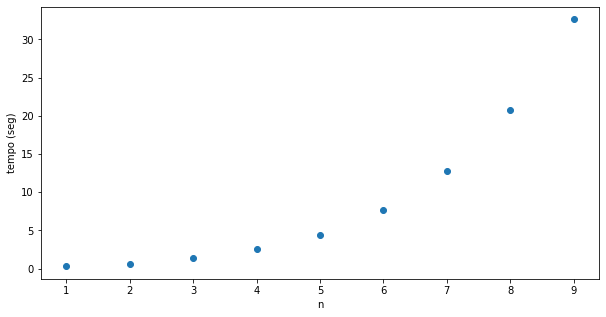

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.scatter(N_exaust_GPU, tempos_exaust_GPU)
plt.show()

Ao executar o programa de paralelização da GPU, descobre-se que o tempo de execução é muito longo, mais longo que a não paralelização. Para poder ao menos gerar uma sequência básica de resultados, foi necessário então mudar a quantidade e o tamanho máximo de sequências de entrada.

O motivo para a execução ser tão longa se dá pelo fato de o código não conseguir se apropriar tanto do recurso de alta vazão da GPU, apenas criar objetos no hardware um depois do outro e não botando todos de uma vez la. Além disso, o ato de colocar dados na GPU é muito demorado , acarretando com o fato de a GPU ser mais demorada que a CPU.

Dessa forma, para melhorar o tempo, foi realizado uma tentativa de envia dois vetores de char para a GPU composta pela sequência A e a sequência B. Com isso, seria feito um transform que calcularia score de uma maneira diferente do Smith Wallerman, em que se os caracteres fossem iguais, a sequencia ganhava dois pontos e caso contrário -1. A única parte mais trabalhosa seria escolher como o transform ia peganado as subsequências escolhendo os índices apropriados para comparar. Infelizmente, esse métodos não foi aplicado mas deveria executa todas as subsquências possíveis, logo, é possível usar o programa para ver se a paralelização da GPU realmente ajuda na economia de tempo. Com isso temos:


# Conclusão

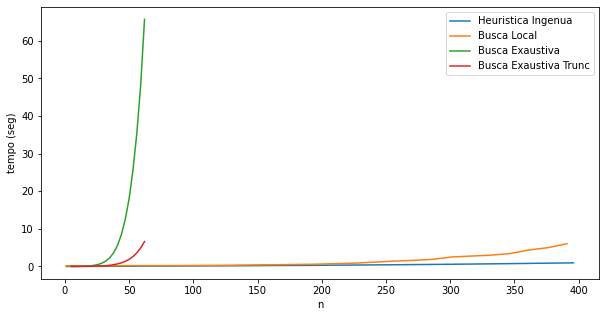

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.plot(N_Heuristica, tempos_Heuristica, label='Heuristica Ingenua')
plt.plot(N_local, tempos_local, label='Busca Local')
ax.plot(N_exaust, tempos_exaust, label='Busca Exaustiva')
plt.plot(N_exaust_trunc, tempos_exaust_trunc, label='Busca Exaustiva Trunc')
plt.legend()
plt.show()

Com o gráfico acima, é facilmente possível de perceber que o algorítimo ingênuo é o mais rápido para qualquer tamanho de entrada e o Busca Exaustiva (com o auxílio do algorítimo de Smith-Wallerman) é extremamente demorado para entradas de n grande. A crescente demora para a relização desses algorítimos (de Ingênuo para busca local, busca exaustiva truncada e busca exaustiva) se dá pelo fato de os mais demorados tem que quebrar as entradas e fazer diversas combinações a mais.

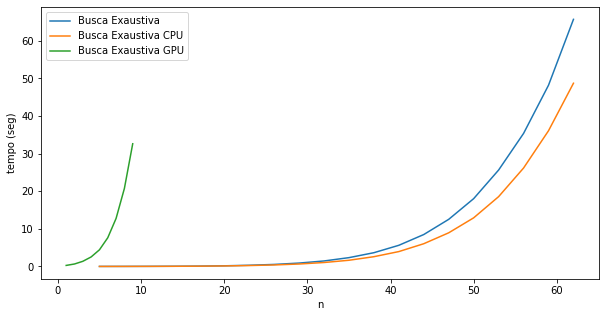

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('n')
ax.set_ylabel('tempo (seg)')
ax.plot(N_exaust, tempos_exaust, label='Busca Exaustiva')
plt.plot(N_exaust_par_cpu, tempos_exaust_par_cpu, label='Busca Exaustiva CPU')
plt.plot(N_exaust_GPU, tempos_exaust_GPU, label='Busca Exaustiva GPU')
plt.legend()
plt.show()

In [56]:
df = pd.DataFrame(list(zip(tempos_exaust, tempos_exaust_par_cpu)),
               columns =['Não paralelizado', 'Paralelizado'])
df

,Não paralelizado,Paralelizado
0,0.012118,0.007852
1,0.020093,0.015766
2,0.034292,0.028193
3,0.058000,0.049036
4,0.098109,0.083010
5,0.176810,0.143990
6,0.322185,0.246446
7,0.542836,0.404086
8,0.904783,0.655249
9,1.464435,1.052666


Pelo gráfico, o Busca Exaustiva paralela da CPU teve um desempenho muito similar ao Busca Exaustiva normal. Para ver quem é melhor, foi montado a tabela acima. Vemos que para ns menores o busca exaustiva normal é um pouco melhor. Isso se dá porque alocar as threads da CPU faz com que demore um poquinho mais, mas, para ns maiores, o paralelizado é relativamente melhor (superior à diferença de ns menores). Por fim, por problemas já expresso a paralelização na GPU é o pior de todos por tratar sequecialmente a GPU, ou seja, já tem a demora sequencial, somado ao fato de a GPU ser mais lerda que a CPU e que existe uma demora de transporte de dados da CPU à GPU.

## Comparação dos resultados:

Para comparar qual algorítimo consegue atingir melhores resultados de pontução foi fixado duas entradas de tamanho 60 tanto para a primeira, quanto para a segunda sequencia

GA-C-TCC-GACACTCAGCCTTCAGGC-G-ATGCGCAT-G--TCCGTCGCA-AAGATT-G
GG-AGT-TGGCA-ATG-G-G-CGTTA-ACC--AG-TGCGCTCGGGA-AC-TCCGAGACG-

Com isso foram obtidos os resultados:

Ingênuo:

Busca local:

Busca exaustiva Smithen Wallerman

Busca exaustiva com truncamento

O ponto interessante da comparação entre os scores dos algorítimos é que o busca exaustiva teve o melhor desempenho, porém não um tão melhor quanto o ingênuo. Isso gera uma dúvida a respeito da relevância de se utilizar o busca exaustiva, já que ele é muito demorado e não possui um resultado tão melhor quanto o ingênuo. Ao mesmo tempo, seria necessário fazer mais testes. 

Além disso, algo curioso foi o resultado do algorítimo aleatório do busca local que obteve um score adequado, podendo ser bem utilizado em cenários para familiarizar com a situação e validar um score de um outro algorítimo.

Por fim, o busca exaustiva com truncamento se demonstrou muito pouco eficiente por ser demorado e possuir um desempenho de score muito ruim.

## Profiling

Realizado vallgrind com a mesma entrada acima

Ingenuo

![SmithIngenuo1.png](attachment:SmithIngenuo1.png)

![passandomatrix.png](attachment:passandomatrix.png)

Busca Local

![busca_local.png](attachment:busca_local.png)

Busca Exaustiva SmithWallerman

![busca_exaustiva_Smith_part.png](attachment:busca_exaustiva_Smith_part.png)

![busca_exaustiva.png](attachment:busca_exaustiva.png)

Busca Exaustiva Trunc

![Busca_exaustiva_trunc.png](attachment:Busca_exaustiva_trunc.png)

Com o uso de vallgrind é possível perceber que em todos os algorítimos o que causa maior lentidão são os fors. Esses deveriam ser evitados para melhorar a lentidão. Além disso, seria melhor se não fosse utlizado matrizes, já que muitas vezes é necessário percorrer por toda ela.